In [2]:
import json 
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import ListedColormap

import torch as t
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

In [3]:
def readJson(file_name):
    with open(file_name, 'r') as f:
        data = json.load(f)
        data['train'] = {
            'input': [np.array(d['input'], dtype=np.int8) for d in data['train']],
            'output': [np.array(d['output'], dtype=np.int8) for d in data['train']],
        }
        data['test'] = {
            'input': [np.array(d['input'], dtype=np.int8) for d in data['test']],
            'output': [np.array(d['output'], dtype=np.int8) for d in data['test']],
        }
    return data

In [22]:
cmap = ListedColormap(['#000000', '#0075d8', '#fe4036', '#2ecc40', '#ffdd01', '#ababaa', '#f113be', '#fe851a', '#7edbfe', '#860d25', ])

def show(img, ax=None):
    if ax:
        ax.imshow(img, cmap=cmap, norm=plt.Normalize(0, 9))
    else:
        plt.imshow(img, cmap=cmap, norm=plt.Normalize(0, 9))
        plt.show()

In [47]:
class Node:
    def __init__(self, value, x, y):
        self.value = value
        self.adj = []
        self.x = x
        self.y = y
        self.visited = False

    def reset(self):
        self.visited = False
        for n in self.adj:
            if n.visited:
                n.reset()

    def draw(self, ax):
        if self.visited: return
        self.visited = True
        # draw node circle
        ax.add_patch(patches.Circle((self.x, self.y), 0.05, fill=True, color='black'))
        for n in self.adj:
            ax.add_patch(patches.ConnectionPatch((self.x, self.y), (n.x, n.y), 
                                                 'data', 
                                                 'data', 
                                                 arrowstyle='->', 
                                                 shrinkA=5, 
                                                 shrinkB=5, 
                                                 mutation_scale=5))
            n.draw(ax)

In [76]:
def createFloodFillGraph(img):
    graphs = []
    rows = img.shape[0]
    cols = img.shape[1]
    visited = np.zeros((rows, cols), dtype=np.int8)

    def floodFill(prev_val, row, col):
        if col < 0 or row < 0 or col >= cols or row >= rows: return None
        if visited[row, col]: return None
        if img[row, col] != prev_val: return None
        if prev_val == 0: return None

        visited[row, col] = 1
        node = Node(prev_val, col, row)
        for dc, dr in [(1, 0), (-1, 0), (0, 1), (0, -1), (1, 1), (-1, -1), (1, -1), (-1, 1)]:
            adj = floodFill(prev_val, row + dr, col + dc)
            if adj:
                node.adj.append(adj)
                adj.adj.append(node)
        return node

    for row in range(rows):
        for col in range(cols):
            head = floodFill(img[row, col], row, col)
            if head:
                graphs.append(head)

    return graphs

In [86]:
training_dir = './data/training/'
# train_file_names = [training_dir + '150deff5.json']
train_file_names = [os.path.join(training_dir, file_name)
                    for file_name in os.listdir(training_dir)]

data = readJson(train_file_names[24])

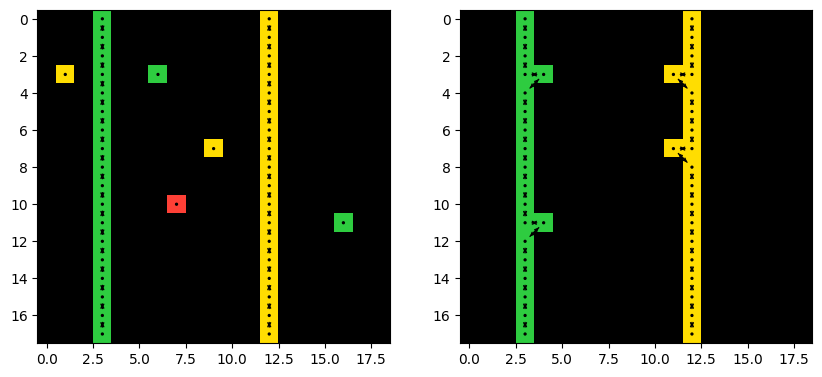

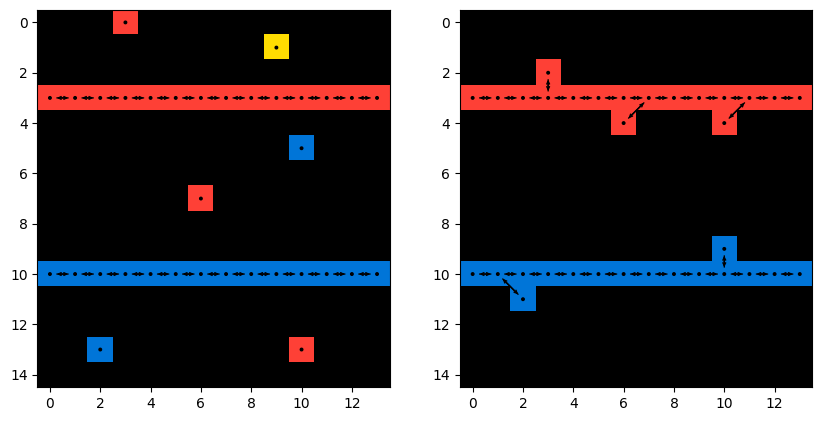

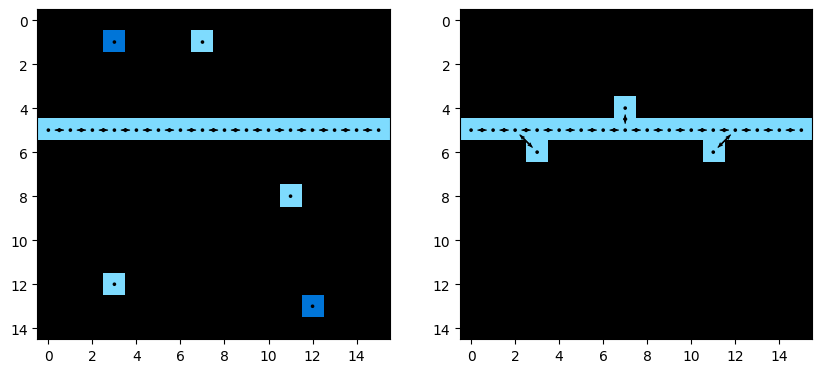

In [87]:
inps = data['train']['input']
outs = data['train']['output']
for inp, out in zip(inps, outs):
    inp_g = createFloodFillGraph(inp)
    out_g = createFloodFillGraph(out)

    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    show(inp, ax1)
    show(out, ax2)

    for g in inp_g:
        g.reset()
        g.draw(ax1)

    for g in out_g:
        g.reset()
        g.draw(ax2)

    plt.show()

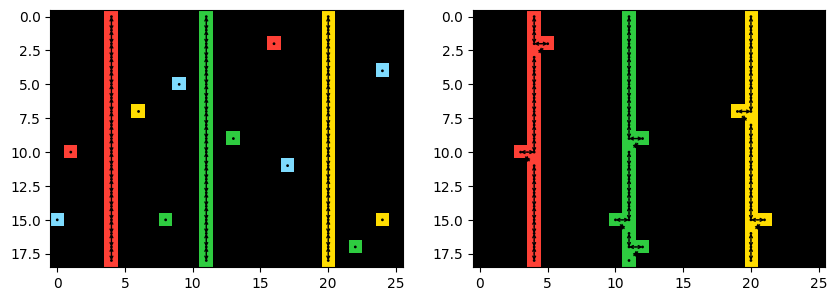

In [88]:
test_inps = data['test']['input']
test_outs = data['test']['output']

for inp, out in zip(test_inps, test_outs):
    inp_g = createFloodFillGraph(inp)
    out_g = createFloodFillGraph(out)

    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    show(inp, ax1)
    show(out, ax2)

    for g in inp_g:
        g.reset()
        g.draw(ax1)

    for g in out_g:
        g.reset()
        g.draw(ax2)

    plt.show()